# Machine Translation Project
Members
* Linda Sekhoasha - 222004139
*
*
*

# Imports
Uncomment the pip commands when running for the first time!

In [2]:
!pip install pandas
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install nltk
!pip install -U datasets
!pip uninstall -y torch torchtext
!pip install torch==2.0.1 torchtext==0.15.2

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
Using cached datasets-3.6.0-py3-none-any.whl (491 kB)
Found existing installation: torch 2.6.0+cu118
Uninstalling torch-2.6.0+cu118:
  Successfully uninstalled torch-2.6.0+cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.7 M

In [1]:
# imports
import string
import random
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datasets
from datasets import load_dataset
import torchtext
from torchtext.vocab import Vocab, build_vocab_from_iterator
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Data Preparation

In [164]:
# uploaded the csv files on HuggingFace for easy usage of dataset
dataset = load_dataset(
    "LindaSekhoasha/zu-en_mt",
    data_files={
        "train": "zu-en.training.csv",
        "validation": "zu-en.eval.csv",
        "test": "zu-en.test.csv"
    }
)

train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)
# show features to work with
print(f"{train_data.features}\n{valid_data.features}\n{test_data.features}")

{'zu': Value(dtype='string', id=None), 'en': Value(dtype='string', id=None)}
{'zu': Value(dtype='string', id=None), 'en': Value(dtype='string', id=None)}
{'zu': Value(dtype='string', id=None), 'en': Value(dtype='string', id=None)}


In [165]:
# function to tokenize a row (example) in dataset using .map function
def tokenize_example(example, max_length, lower, sos_token, eos_token):
    zu_tokens = word_tokenize(example["zu"])[:max_length]
    en_tokens = word_tokenize(example["en"])[:max_length]
    if lower:
        zu_tokens = [token.lower() for token in zu_tokens]
        en_tokens = [token.lower() for token in en_tokens]
    zu_tokens = [sos_token] + zu_tokens + [eos_token]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    return {"zu_tokens": zu_tokens, "en_tokens": en_tokens}


# maybe try with spacy (treating zulu as english and tokenize both with en_nlp?)

In [166]:
max_length = 500
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

In [193]:
# define special tokens
specials = ['<unk>', '<pad>']

# build vocab from tokens in training data
zu_vocab = build_vocab_from_iterator(
    train_data["zu_tokens"],
    min_freq=2,       # only include tokens that appear at least 2 times maybe?
    specials=specials
)

en_vocab = build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=2,
    specials=specials
)

# set the default index for unknown tokens (important!)
zu_vocab.set_default_index(zu_vocab['<unk>'])
en_vocab.set_default_index(en_vocab['<unk>'])

In [168]:
# show items in vocab, torchtext adds unk and pad tokens
# unk is for words in valid and test but not in train
zu_vocab.get_itos()[:10]

['<unk>', '<pad>', '.', '<eos>', '<sos>', ',', 'ukuthi', ':', '(', ')']

In [169]:
# function to convert tokens in vocab to indices
def numericalize_example(example, zu_vocab, en_vocab):
    zu_ids = zu_vocab.lookup_indices(example["zu_tokens"])
    en_ids = en_vocab.lookup_indices(example["en_tokens"])

    return {"zu_ids": zu_ids, "en_ids": en_ids}

In [170]:
# use .map function to iteratively use the numericalize_example function
fn_kwargs = {"zu_vocab": zu_vocab, "en_vocab": en_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/4960 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

Map:   0%|          | 0/487 [00:00<?, ? examples/s]

In [171]:
# show new features in an example (zu_ids and en_ids)
train_data[0]

{'zu': 'Lomkhakha kufanele uthuthukiswe, lawa amazwi kaSomlomo, uLogie Naidoo ekhuluma kwinkomfa nombukiso wobuciko ebuse Durban ICC ngesonto elidlule.',
 'en': 'This sector needs to be developed,  These are the words of Speaker, Logie Naidoo, from a conference and art exhibition held at the Durban ICC last week.',
 'zu_tokens': ['<sos>',
  'lomkhakha',
  'kufanele',
  'uthuthukiswe',
  ',',
  'lawa',
  'amazwi',
  'kasomlomo',
  ',',
  'ulogie',
  'naidoo',
  'ekhuluma',
  'kwinkomfa',
  'nombukiso',
  'wobuciko',
  'ebuse',
  'durban',
  'icc',
  'ngesonto',
  'elidlule',
  '.',
  '<eos>'],
 'en_tokens': ['<sos>',
  'this',
  'sector',
  'needs',
  'to',
  'be',
  'developed',
  ',',
  'these',
  'are',
  'the',
  'words',
  'of',
  'speaker',
  ',',
  'logie',
  'naidoo',
  ',',
  'from',
  'a',
  'conference',
  'and',
  'art',
  'exhibition',
  'held',
  'at',
  'the',
  'durban',
  'icc',
  'last',
  'week',
  '.',
  '<eos>'],
 'zu_ids': [4,
  5501,
  43,
  20930,
  5,
  1898,
  

In [172]:
# convert indices to PyTorch tensors for use with PyTorch
data_type = "torch"
format_columns = ["zu_ids", "en_ids"]

train_data = train_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

# show new type of indices
type(train_data[0]["en_ids"])

torch.Tensor

In [173]:
# function for padding our examples and getting 'batches'
# batches - set of examples
# padding_index = 1 by default.
def get_collate_fn():
    def collate_fn(batch):
        batch_zu_ids = [example["zu_ids"] for example in batch]
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_zu_ids = nn.utils.rnn.pad_sequence(batch_zu_ids, padding_value=1)
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=1)
        batch = {
            "zu_ids": batch_zu_ids,
            "en_ids": batch_en_ids,
        }
        return batch

    return collate_fn

In [174]:
# function to get the data loader
def get_data_loader(dataset, batch_size, shuffle=False):
    collate_fn = get_collate_fn()
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [175]:
# create data loaders
# note: larger batch size needs more GPU power but trains faster
batch_size = 32

train_data_loader = get_data_loader(train_data, batch_size, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size)
test_data_loader = get_data_loader(test_data, batch_size)

# Model

## Encoder

In [176]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

## Decoder

In [177]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, hidden, cell

## Seq2Seq

In [178]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        # input = [batch size]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

# Train

In [179]:
input_dim = len(en_vocab)
output_dim = len(zu_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [180]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8983, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(22996, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=22996, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [181]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 27,339,988 trainable parameters


In [182]:
# optimizer
optimizer = optim.Adam(model.parameters())

In [183]:
# Loss Function
pad_index = 1
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [184]:
# training loop
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["en_ids"].to(device)
        trg = batch["zu_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [185]:
# evaluation loop
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["en_ids"].to(device)
            trg = batch["zu_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [186]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

# log variables for graph visualizations
train_losses = []
valid_losses = []
train_ppls = []
valid_ppls = []

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    # save the model only if validation loss improves
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")

    # perplexity calculation
    train_ppl = np.exp(train_loss)
    valid_ppl = np.exp(valid_loss)

    # log and track
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_ppls.append(train_ppl)
    valid_ppls.append(valid_ppl)

    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {train_ppl:7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {valid_ppl:7.3f}")

 10%|█         | 1/10 [00:32<04:53, 32.66s/it]

	Train Loss:   8.409 | Train PPL: 4487.123
	Valid Loss:   8.173 | Valid PPL: 3542.834


 20%|██        | 2/10 [01:04<04:18, 32.33s/it]

	Train Loss:   7.776 | Train PPL: 2382.119
	Valid Loss:   8.326 | Valid PPL: 4131.894


 30%|███       | 3/10 [01:36<03:45, 32.28s/it]

	Train Loss:   7.553 | Train PPL: 1906.162
	Valid Loss:   8.413 | Valid PPL: 4505.486


 40%|████      | 4/10 [02:09<03:13, 32.20s/it]

	Train Loss:   7.336 | Train PPL: 1534.066
	Valid Loss:   8.512 | Valid PPL: 4971.935


 50%|█████     | 5/10 [02:41<02:40, 32.19s/it]

	Train Loss:   7.115 | Train PPL: 1229.961
	Valid Loss:   8.603 | Valid PPL: 5450.594


 60%|██████    | 6/10 [03:13<02:09, 32.27s/it]

	Train Loss:   6.925 | Train PPL: 1017.363
	Valid Loss:   8.731 | Valid PPL: 6192.032


 70%|███████   | 7/10 [03:45<01:36, 32.10s/it]

	Train Loss:   6.728 | Train PPL: 835.287
	Valid Loss:   8.860 | Valid PPL: 7045.910


 80%|████████  | 8/10 [04:17<01:04, 32.08s/it]

	Train Loss:   6.539 | Train PPL: 691.905
	Valid Loss:   8.947 | Valid PPL: 7686.086


 90%|█████████ | 9/10 [04:49<00:31, 31.99s/it]

	Train Loss:   6.350 | Train PPL: 572.231
	Valid Loss:   9.034 | Valid PPL: 8384.252


100%|██████████| 10/10 [05:21<00:00, 32.13s/it]

	Train Loss:   6.147 | Train PPL: 467.147
	Valid Loss:   9.142 | Valid PPL: 9341.753


# Graphs and Visualizations

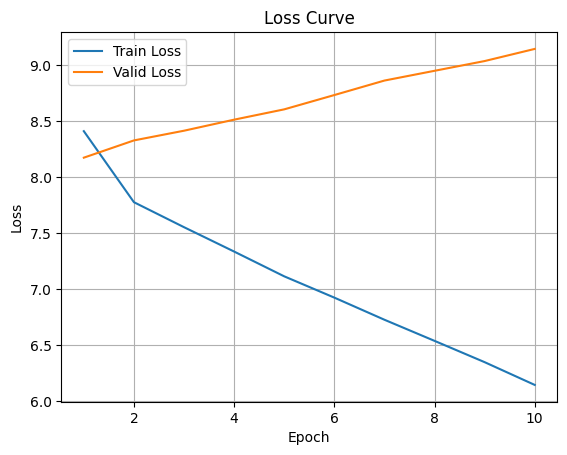

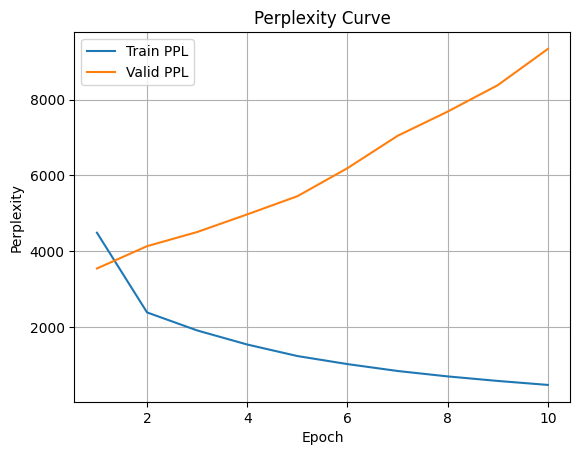

In [187]:
epochs = range(1, n_epochs + 1)

# plot Loss
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# plot Perplexity
plt.figure()
plt.plot(epochs, train_ppls, label='Train PPL')
plt.plot(epochs, valid_ppls, label='Valid PPL')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity Curve')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation

In [188]:
model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 8.130 | Test PPL: 3394.742 |


In [189]:
# use the model to translate sentences -> getting to BLEU score
def translate_sentence(
    sentence,
    model,
    zu_vocab,
    en_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = word_tokenize(sentence)
        else:
            tokens = [token for token in sentence]
        if lower:
            tokens = [token.lower() for token in tokens]
        tokens = [sos_token] + tokens + [eos_token]
        ids = en_vocab.lookup_indices(tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        hidden, cell = model.encoder(tensor)
        inputs = zu_vocab.lookup_indices([sos_token])
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == zu_vocab[eos_token]:
                break
        tokens = zu_vocab.lookup_tokens(inputs)
    return tokens

In [194]:
sentence = test_data[0]["en"]
expected_translation = test_data[0]["zu"]

sentence, expected_translation

('NONDUDUZO NGCONGO SEKUVELILE ukuthi ezokuvakasha zibamba elikhulu iqhaza uma kuziwa ngasemnothweni waseThekwini naseNingizimu Afrika.',
 'NONDUDUZO NGCONGO It has come to light that tourism plays a major role in the economy of Durban and South Africa.')

In [195]:
translation = translate_sentence(
    sentence,
    model,
    zu_vocab,
    en_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

# show translation
translation

['<sos>', 'lo', ':', ':', ',', ',', ',', ',', ',', ',', '.', '.', '.', '<eos>']